# Maximizing accuracy under fairness constraints (C-SVM and C-LR)

In [19]:
from __future__ import division
import matplotlib
import pandas as pd
import numpy as np

# import urllib2
import os,sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
import a2_loss_funcs as lf 
import a2_utils as ut
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv("compas-scores-two-years.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [21]:
df.shape

(7214, 53)

#### Performing Exploratory Data Analysis

In [22]:
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


#### Checking for missing values

In [23]:
print(df.isnull().sum())

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

#### Distribution Plot of Age

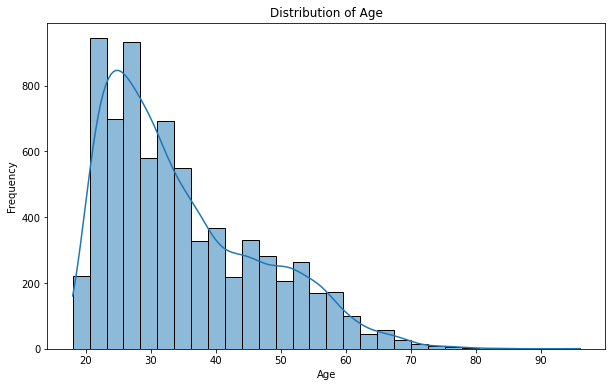

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#### Race v/s Count

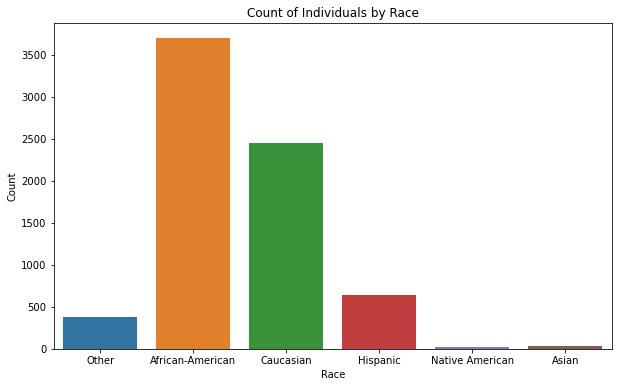

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='race', data=df)
plt.title('Count of Individuals by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

## Preprocessing

Selecting the features we will use for analysis, the target variable and the sensitive attributes

In [27]:
FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree", 'score_text', 'decile_score']
CONT_VARIABLES = ["priors_count", "decile_score"] 
CLASS_FEATURE = "two_year_recid" 
SENSITIVE_ATTRS = ["race"]

In [28]:
for column in FEATURES_CLASSIFICATION:
    print(column)
    print(df[column].unique())
    print("--------------------------")

age_cat
['Greater than 45' '25 - 45' 'Less than 25']
--------------------------
race
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']
--------------------------
sex
['Male' 'Female']
--------------------------
priors_count
[ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
--------------------------
c_charge_degree
['F' 'M']
--------------------------
score_text
['Low' 'High' 'Medium']
--------------------------
decile_score
[ 1  3  4  8  6 10  5  9  2  7]
--------------------------


In [29]:
df = df.dropna(subset=["days_b_screening_arrest"]) 
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])


The following preprocessing steps are taken based on the [propublica GitHub page](https://github.com/propublica/compas-analysis)


- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [30]:
idx = np.logical_and(data["days_b_screening_arrest"]<=30, data["days_b_screening_arrest"]>=-30)

idx = np.logical_and(idx, data["is_recid"] != -1)

idx = np.logical_and(idx, data["c_charge_degree"] != "O") 

idx = np.logical_and(idx, data["score_text"] != "NA")

idx = np.logical_and(idx, np.logical_or(data["race"] == "African-American", data["race"] == "Caucasian"))

for k in data.keys():
    data[k] = data[k][idx]

In [31]:
unique_values, value_counts = np.unique(data['race'], return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

African-American: 3175
Caucasian: 2103


In [32]:
y = data[CLASS_FEATURE]
y[y==0] = -1

print("Number of people recidivating within two years")
print(pd.Series(y).value_counts())

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


In [33]:
X = np.array([]).reshape(len(y), 0) 
x_control = defaultdict(list)

Convert the discrete variables to one-hot encoded columns and scale the continuous variables

In [34]:
feature_names = []
for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) 
        vals = np.reshape(vals, (len(y), -1)) 

    else: 
        lb = preprocessing.LabelBinarizer()
        lb.fit(vals)
        vals = lb.transform(vals)

    # add to sensitive features dict
    if attr in SENSITIVE_ATTRS:
        x_control[attr] = vals


    # add to learnable features
    X = np.hstack((X, vals))

    if attr in CONT_VARIABLES: # continuous feature, just append the name
        feature_names.append(attr)
    else: # categorical features
        if vals.shape[1] == 1: # binary features that passed through lib binarizer
            feature_names.append(attr)
        else:
            for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
                feature_names.append(attr + "_" + str(k))

In [35]:
# convert the sensitive feature to 1-d array
x_control = dict(x_control)
for k in x_control.keys():
    assert(x_control[k].shape[1] == 1) # make sure that the sensitive feature is binary after one hot encoding
    x_control[k] = np.array(x_control[k]).flatten()

In [36]:
perm = list(range(0, X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
for k in x_control.keys():
    x_control[k] = x_control[k][perm]


In [37]:
X = ut.add_intercept(X)

feature_names = ["intercept"] + feature_names
assert(len(feature_names) == X.shape[1])
print ("Features we will be using for classification are:", feature_names, "\n")


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree', 'score_text_High', 'score_text_Low', 'score_text_Medium', 'decile_score'] 



Compute the p-rule in the original data

In [38]:
ut.compute_p_rule(x_control["race"], y) 


Total data points: 5278
# non-protected examples: 2103
# protected examples: 3175
Non-protected in positive class: 822 (39%)
Protected in positive class: 1661 (52%)
P-rule is: 134%


133.84228978676936

Split the data into train and test


In [39]:
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)


## Logictic Regression

Normal Logistic Regression without applying fairness constraints. For this the the "apply_fairness_constraints" value should be set to 0.

In [40]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 0
sep_constraint = 0

loss_function = lf._logistic_loss
sensitive_attrs = ["race"]
sensitive_attrs_to_cov_thresh = {}
gamma = None

In [41]:
w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
distances_boundary_test = (np.dot(x_test, w)).tolist()
all_class_labels_assigned_test = np.sign(distances_boundary_test)
correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	


Accuracy: 0.70
Protected/non-protected in +ve class: 50% / 25%
P-rule achieved: 204%
Covariance between sensitive feature and decision from distance boundary : 0.148


Logistic Regression with fairness constraints. For this the the "apply_fairness_constraints" value should be set to 1 and the "sensitive_attrs_to_cov_thresh" should pass the dict of fairness column.

In [42]:
apply_fairness_constraints = 1
apply_accuracy_constraint = 0
sep_constraint = 0

loss_function = lf._logistic_loss
sensitive_attrs = ["race"]
sensitive_attrs_to_cov_thresh = {"race":0}
gamma = None

In [43]:
w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
distances_boundary_test = (np.dot(x_test, w)).tolist()
all_class_labels_assigned_test = np.sign(distances_boundary_test)
correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	


Accuracy: 0.69
Protected/non-protected in +ve class: 42% / 38%
P-rule achieved: 110%
Covariance between sensitive feature and decision from distance boundary : 0.000


## Support Vector Machine

Without fairness

In [44]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 0
sep_constraint = 0

loss_function = lf._hinge_loss
sensitive_attrs = ["race"]
sensitive_attrs_to_cov_thresh = {}
gamma = None

In [45]:
w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
distances_boundary_test = (np.dot(x_test, w)).tolist()
all_class_labels_assigned_test = np.sign(distances_boundary_test)
correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	


Accuracy: 0.67
Protected/non-protected in +ve class: 57% / 32%
P-rule achieved: 179%
Covariance between sensitive feature and decision from distance boundary : 0.120


With fairness

In [46]:
apply_fairness_constraints = 1
apply_accuracy_constraint = 0
sep_constraint = 0

loss_function = lf._hinge_loss
sensitive_attrs = ["race"]
sensitive_attrs_to_cov_thresh = {"race":0}
gamma = None

In [47]:
w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
distances_boundary_test = (np.dot(x_test, w)).tolist()
all_class_labels_assigned_test = np.sign(distances_boundary_test)
correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	


Accuracy: 0.67
Protected/non-protected in +ve class: 56% / 32%
P-rule achieved: 174%
Covariance between sensitive feature and decision from distance boundary : 0.002
